# Time Series Breakdown of Retail Sales


### Description
- Dataset (Recommended): Walmart Sales Forecasting (Kaggle)  
- Analyze a retail dataset with monthly sales  
- Plot trends, moving averages, and seasonal patterns  
- Break down revenue by product and region over time  


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
import calendar

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv("C:/Users/HP/Downloads/train.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
277665,29,5,2010-02-05,15552.08,False
277808,29,6,2010-02-05,3200.22,False
277951,29,7,2010-02-05,10820.05,False
278094,29,8,2010-02-05,20055.64,False


In [16]:

monthly_sales = df.groupby('Date')['Weekly_Sales'].sum().resample('M').sum()
monthly_sales.head()


Date
2010-02-28    1.903330e+08
2010-03-31    1.819198e+08
2010-04-30    2.314124e+08
2010-05-31    1.867109e+08
2010-06-30    1.922462e+08
Freq: ME, Name: Weekly_Sales, dtype: float64

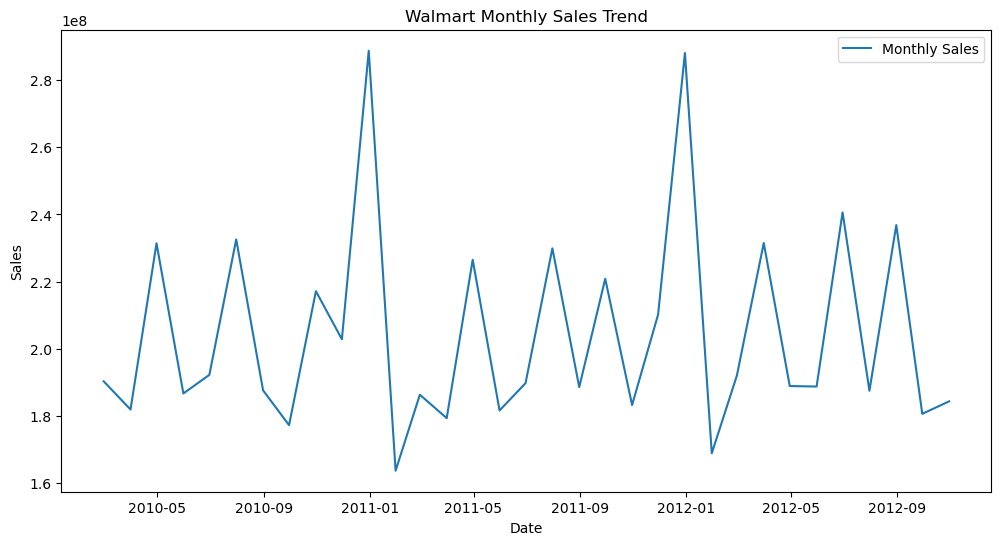

In [5]:

plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label="Monthly Sales")
plt.title("Walmart Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


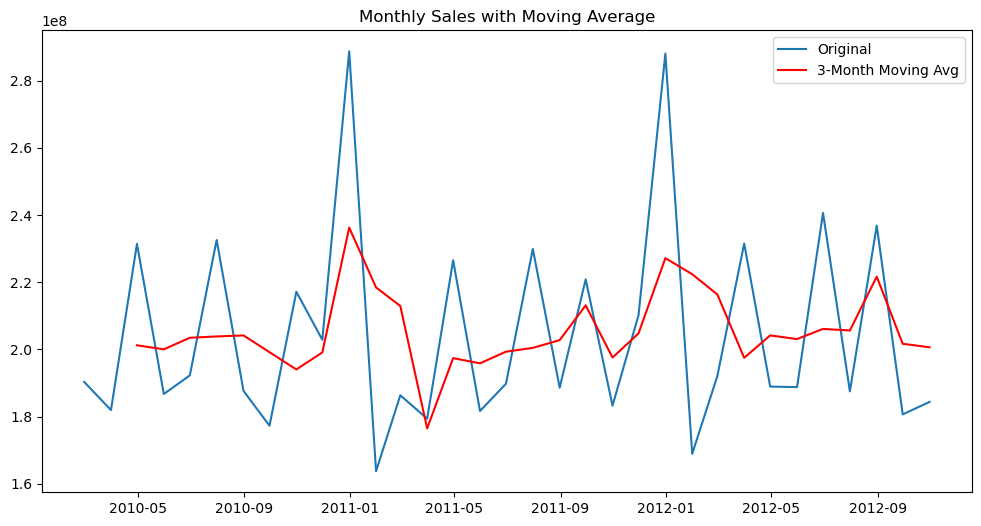

In [6]:

monthly_sales_ma = monthly_sales.rolling(window=3).mean()

plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label="Original")
plt.plot(monthly_sales_ma, label="3-Month Moving Avg", color="red")
plt.title("Monthly Sales with Moving Average")
plt.legend()
plt.show()


<Axes: title={'center': 'Product 1 Monthly Sales'}, xlabel='Date'>

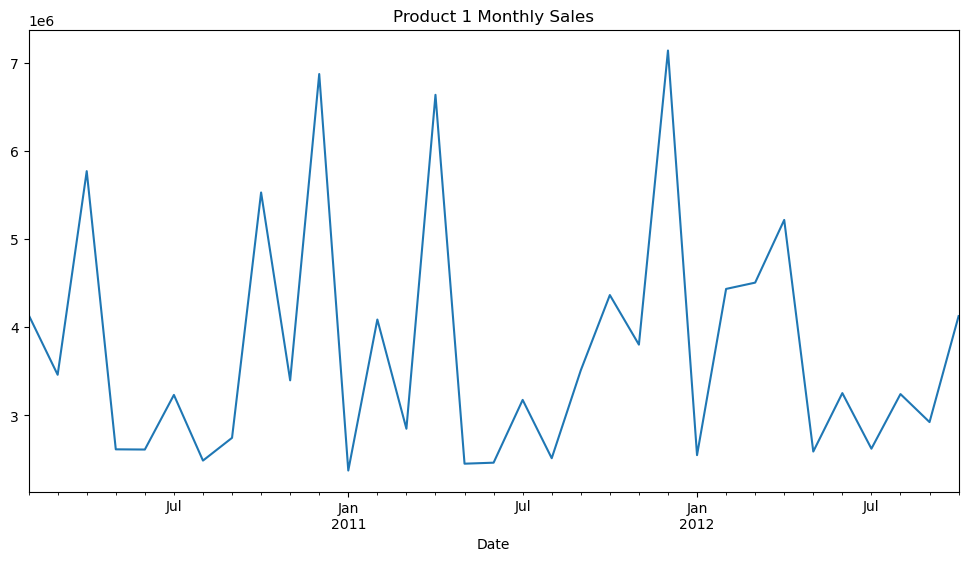

In [17]:
product_sales = df.groupby(['Date', 'Dept'])['Weekly_Sales'].sum().unstack().resample('M').sum()
product_sales[1].plot(figsize=(12,6), title="Product 1 Monthly Sales")

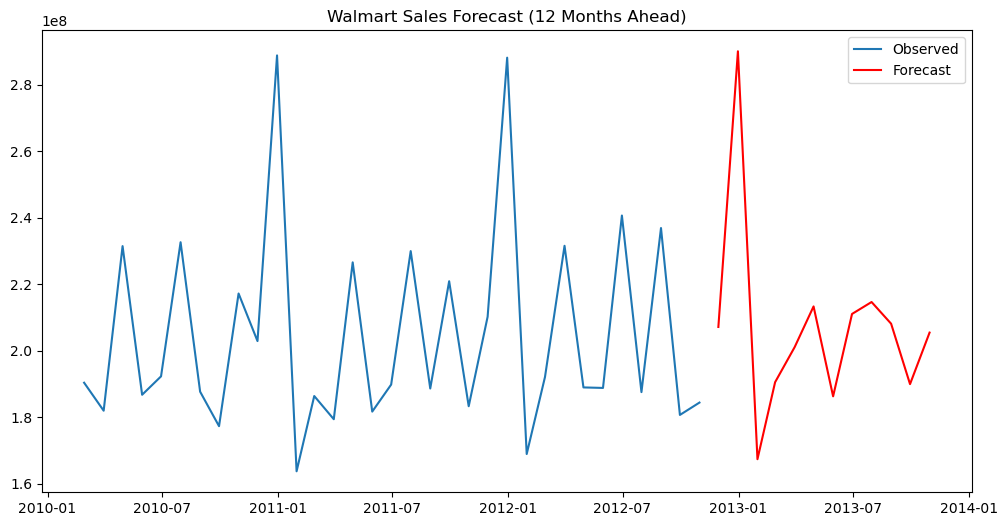

In [18]:
model = ExponentialSmoothing(monthly_sales, trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
forecast = fit.forecast(12)

plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label="Observed")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.title("Walmart Sales Forecast (12 Months Ahead)")
plt.show()

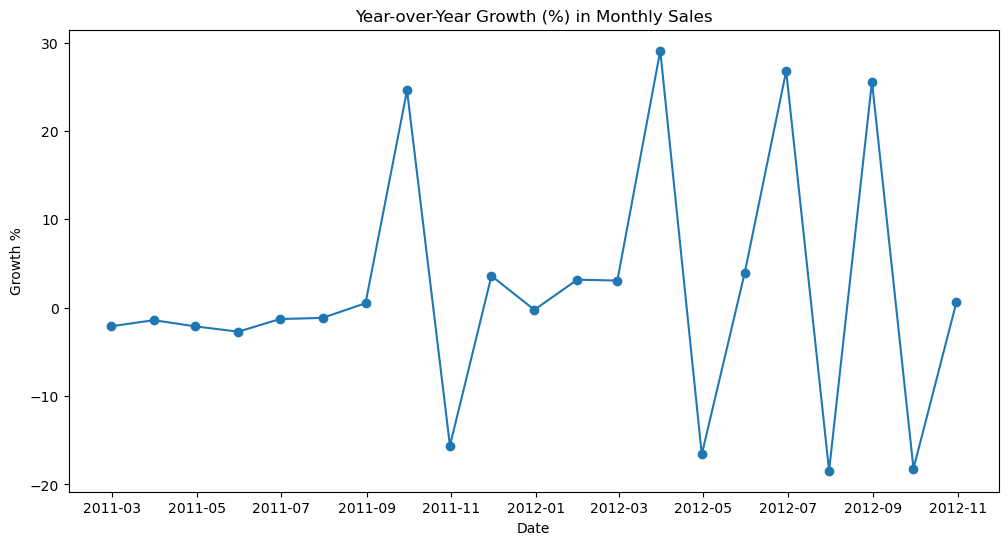

In [14]:
yoy_growth = monthly_sales.pct_change(12) * 100

plt.figure(figsize=(12,6))
plt.plot(yoy_growth, marker='o')
plt.title("Year-over-Year Growth (%) in Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Growth %")
plt.show()

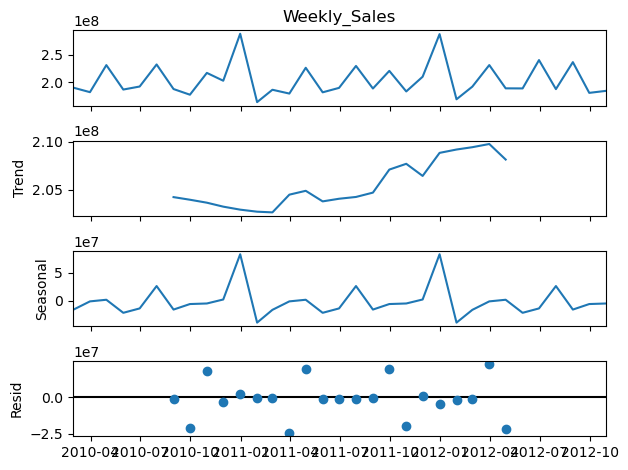

In [7]:

decomposition = seasonal_decompose(monthly_sales, model='additive')
decomposition.plot()
plt.show()


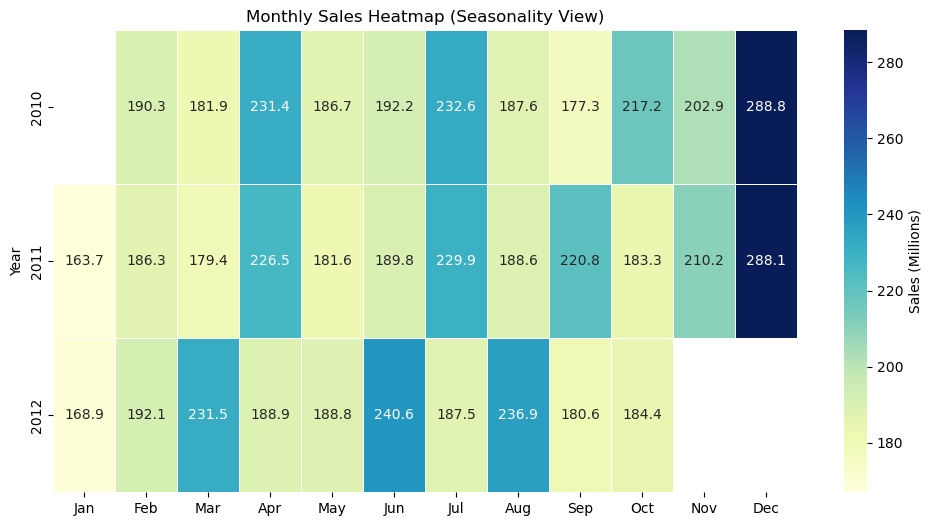

In [8]:

heatmap_data = monthly_sales.copy().to_frame(name="Sales")
heatmap_data["Year"] = heatmap_data.index.year
heatmap_data["Month"] = heatmap_data.index.month

pivot = heatmap_data.pivot(index="Year", columns="Month", values="Sales") / 1e6
pivot.columns = [calendar.month_abbr[m] for m in pivot.columns]

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".1f", robust=True, linewidths=0.5, cbar_kws={'label': 'Sales (Millions)'})
plt.title("Monthly Sales Heatmap (Seasonality View)")
plt.show()


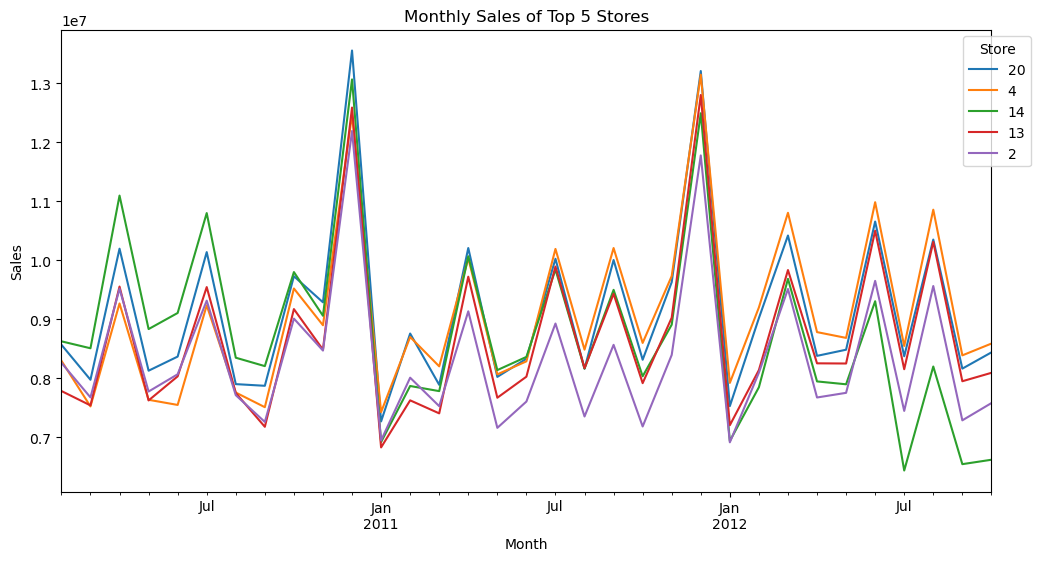

In [25]:

store_sales = df.groupby(['Store','Date'])['Weekly_Sales'].sum().reset_index()
store_monthly = store_sales.set_index('Date').groupby('Store')['Weekly_Sales'].resample('ME').sum().unstack(level=0)

top_stores = df.groupby('Store')['Weekly_Sales'].sum().nlargest(5).index
store_monthly_top = store_monthly[top_stores]

store_monthly_top.plot(figsize=(12,6))
plt.title("Monthly Sales of Top 5 Stores")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend(title="Store", bbox_to_anchor=(1.05, 1))
plt.show()


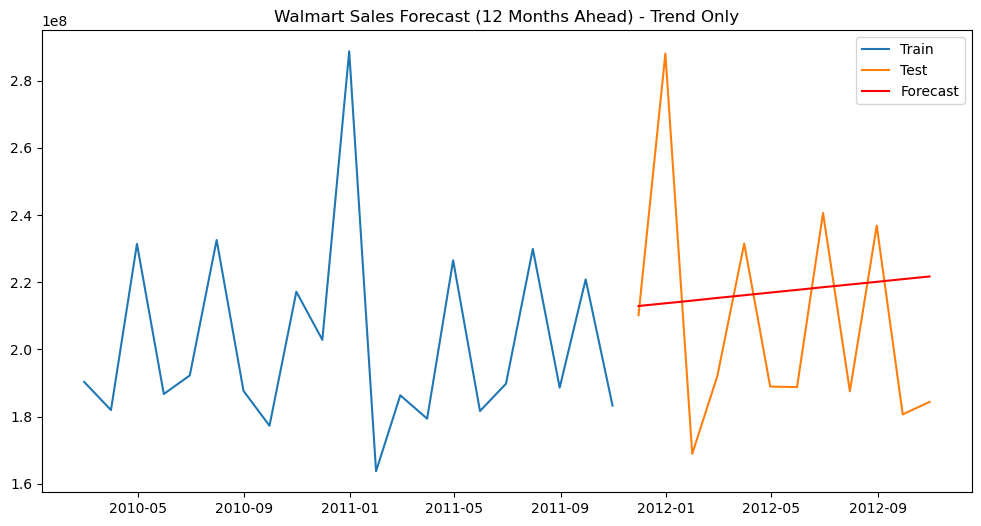

MAPE: 14.90%


In [28]:
train = monthly_sales[:-12]
test = monthly_sales[-12:]

model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=None,
    initialization_method="estimated"
).fit()

# Forecast 12 months ahead
pred = model.forecast(12)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(pred, label="Forecast", color="red")
plt.legend()
plt.title("Walmart Sales Forecast (12 Months Ahead) - Trend Only")
plt.show()

# MAPE
mape = mean_absolute_percentage_error(test, pred) * 100
print(f"MAPE: {mape:.2f}%")
